# Assignment 1: Comparison of Multivariate Linear Regression Models

### CS 6316 Machine Learning - Department of Computer Science - University of Virginia
*In this assignment, you will get to pick your favorite data set on Kaggle (https://kaggle.com) and implement some learning models in a context of a **regression** problem.  For references, you may refer to [my slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit#slide=id.p) or Chapter 4 of the textbook if you need additional sample codes to help with your assignment. To get started, you will need to determine which dataset to download and copy it into the directory where you wish to run your implementation (ie. same folder as this file).* 

*For deliverables, you must write code in Python and submit **this** Jupyter Notebook file (.ipynb) to earn a total of 100 pts. You will gain points depending on how you perform in the following sections.*


***
## 1. BIG PICTURE (5 pts)
Write a paragraph explaining the context of the problem in which you are trying to investigate. In the same paragraph, explain why you pick your dataset. Then, you MUST include the URL to the dataset to help the TA to download it (we will assume that the data file is put into the same folder as the Jupyter Notebook file). Then, you can write some code to load the CSV file and take a quick look at the dataset, and output the following:

 * How big is your dataset? (in terms of MB)
 * How many entries does it have?
 * How many features does it have?
 * What are some basic statistics you can learn right away about this dataset?

In [1]:
# Import some common packages
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import requests
import zipfile

# to make this notebook's output stable across runs
np.random.seed(42)

# Your code goes here for this section, make sure you also include the output to answer the above questions.

datasetURL = "https://www.kaggle.com/mohansacharya/graduate-admissions/downloads/graduate-admissions.zip/1"; # required url to download for CSV file. The TA will download and run your program.

data = pd.read_csv('./Admission_Predict.csv')

In [2]:
#rename the column, since they contain ' ' in the name
data.columns = ['serial','gre_score', 'toefl_score', 'university_ranking','sop','lor','cgpa','research','chance_of_admit']

#drop the irrelevant 'serial' column
data = data.drop('serial', axis=1)

In [3]:
#prints dataset size, number of features (columns) and number of samples
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 8 columns):
gre_score             400 non-null int64
toefl_score           400 non-null int64
university_ranking    400 non-null int64
sop                   400 non-null float64
lor                   400 non-null float64
cgpa                  400 non-null float64
research              400 non-null int64
chance_of_admit       400 non-null float64
dtypes: float64(4), int64(4)
memory usage: 25.1 KB
None


In [4]:
#basic statistics about the dataset
print(data.describe())

        gre_score  toefl_score  university_ranking         sop         lor  \
count  400.000000   400.000000          400.000000  400.000000  400.000000   
mean   316.807500   107.410000            3.087500    3.400000    3.452500   
std     11.473646     6.069514            1.143728    1.006869    0.898478   
min    290.000000    92.000000            1.000000    1.000000    1.000000   
25%    308.000000   103.000000            2.000000    2.500000    3.000000   
50%    317.000000   107.000000            3.000000    3.500000    3.500000   
75%    325.000000   112.000000            4.000000    4.000000    4.000000   
max    340.000000   120.000000            5.000000    5.000000    5.000000   

             cgpa    research  chance_of_admit  
count  400.000000  400.000000       400.000000  
mean     8.598925    0.547500         0.724350  
std      0.596317    0.498362         0.142609  
min      6.800000    0.000000         0.340000  
25%      8.170000    0.000000         0.640000  
50%

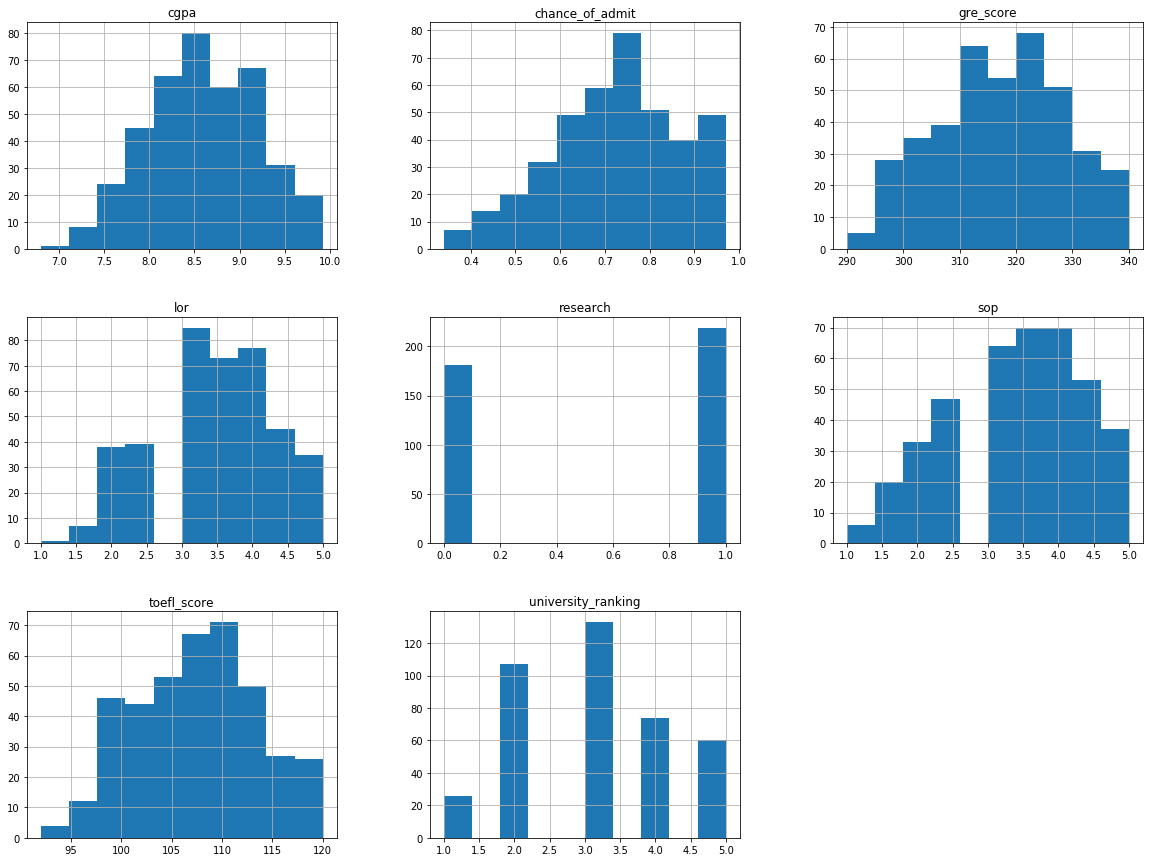

In [5]:
#plot histograms for the columns
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=10, figsize=(20,15))
plt.show()

---
## 2. DATA DISCOVERY, CLEANING, AND SCALING (10 pts)

**Data Discover:** Plot out all correlations among the features. You may notice some features are more correlated with your predicted value than other. This information will help you confirm that weights of your regression model later on.

**Data Cleaning:** If your dataset has some missing values, make sure you are able to fill those values with the Imputer class. If your dataset has categorical features, make sure you conver those features into numerical using OneHotEncoder class. 

**Feature Scaling** More importantly, your task is to write some codes to normalize the value of each features as follow:

* Subtract the mean value of each feature from the dataset
* Scale (divide) the feature values by their respective standard deviation

Implementation Note: You will do this for all features and your code should work with datasets of all sizes (any number of features/ examples). After learning the parameters from the model, you must first normalize the new $x$ value using the mean and standard deviation that you have previously computed from the training set.

In [6]:
#correlation_matrix
print(data.corr())

                    gre_score  toefl_score  university_ranking       sop  \
gre_score            1.000000     0.835977            0.668976  0.612831   
toefl_score          0.835977     1.000000            0.695590  0.657981   
university_ranking   0.668976     0.695590            1.000000  0.734523   
sop                  0.612831     0.657981            0.734523  1.000000   
lor                  0.557555     0.567721            0.660123  0.729593   
cgpa                 0.833060     0.828417            0.746479  0.718144   
research             0.580391     0.489858            0.447783  0.444029   
chance_of_admit      0.802610     0.791594            0.711250  0.675732   

                         lor      cgpa  research  chance_of_admit  
gre_score           0.557555  0.833060  0.580391         0.802610  
toefl_score         0.567721  0.828417  0.489858         0.791594  
university_ranking  0.660123  0.746479  0.447783         0.711250  
sop                 0.729593  0.718144  0.4

In [7]:
#check if our dataset contain any null values, our dataset also has no categorical value
#pd.isnull(data).any(axis=1)

In [8]:
# You might want to use the following package
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix # optional
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Your code goes here for this section.
Y_data = data['chance_of_admit']
X_data = data.drop('chance_of_admit', axis=1)

#Feature_scaling
X_data = preprocessing.scale(X_data)
Y_data = preprocessing.scale(Y_data)

#train-test split
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.15, random_state=42)

#since train_test_split internally permutes the samples, we don't apply external permuation on dataset

y_train = y_train[:,np.newaxis]
y_test = y_test[:,np.newaxis]

print("Train set shape: ", X_train.shape)
print(y_train.shape)
print("Test set shape: ", X_test.shape)
print(y_test.shape)


Train set shape:  (340, 7)
(340, 1)
Test set shape:  (60, 7)
(60, 1)


- - -
## 3. IMPLEMENTATION OF GRADIENT DESCENT (45 pts)
The gradient descent formulation remain the same as one in the lecture. You should write code to implement the **MyLinearRegression** class and its predefined methods:

* **Gradient Descent:** Notes that you may NOT call the library linear regression which defeats the purpose of this assignment. Make sure your code supports any number of features and is well-vectorized.

In [9]:
# NOTE: You may not use the library Linear Regression, but implement your own!
# REMEMBER to place self.attribute = 0 with value from your implementation

class MyLinearRegression:
    def __init__ (self):
        self.theta = 0 # parameter vector;
        self.alpha = 0.001; # learning rate
        self.cost  = 0; # cost function
        self.all_costs = []
  
    def fitUsingGradientDescent(self, X_train, y_train):
        # implementation code here
        theta = np.random.random((X_train.shape[1], 1))  # shape = n x 1;

        (updated_theta, updated_cost) = self.gradientDescent(X_train, y_train, theta, self.alpha, 500)

        self.theta = updated_theta
        self.cost = updated_cost
    
    def gradientDescent(self, X_train, y_train, theta, alpha, iters):
        # INPUT:
        # alpha: the learning rate
        # iters: number of iterations
        # 
        # OUTPUT: 
        # theta: updated value for theta
        # cost: value of the cost function
        #
        # implementation code here
        for i in range(iters):
            delta_cost = X_train.T.dot(X_train.dot(theta) - y_train) * (2 / X_train.shape[0])
            theta = theta - (alpha*delta_cost)
            
            self.all_costs.append(self.computeCostFunc(X_train, y_train, theta))
            
        final_cost = self.computeCostFunc(X_train, y_train, theta)
        return (theta, final_cost)
    
    def computeCostFunc(self, X_train, y_train, theta): 
        # compute the cost function 
        #implementation code here
        result_cost = (np.sum((np.dot(X_train, theta) - y_train)**2))/ X_train.shape[0]
        return result_cost

    def predict(self, X_test):
        # implementation code here
        y_predict = np.dot(X_test,self.theta)
        return y_predict
    
    
    def fitUsingNormalEquation(self, X_train, y_train):
        # implementation code here
        self.theta = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(y_train)
        self.cost = self.computeCostFunc(X_train, y_train, self.theta)
    
# Your code goes here to call the instance of class MyLinearRegression
learning_rates = np.arange(0.001, 0.01, 0.002) #increase rate 0.002 at each iteration, and store them for drawing figure.
cost_for_rates = []
for l_rate in learning_rates:
    print(l_rate)
    myGradientDescentModel = MyLinearRegression()
    myGradientDescentModel.alpha = l_rate
    myGradientDescentModel.fitUsingGradientDescent(X_train, y_train)
    cost_for_rates.append(myGradientDescentModel.all_costs)
    
myGradientDescentModel = MyLinearRegression()
myGradientDescentModel.alpha = 0.007
myGradientDescentModel.fitUsingGradientDescent(X_train, y_train)

0.001
0.003
0.005
0.007
0.009000000000000001


* **Learning Rate:** You will try out different learning rates for the dataset and find a learning rate that converges quickly. If you pick a learning rate, your plot of Cost Function $J(\theta)$ against number of iteration will quickly decay to a small value. This also indicates that your implementation is correct. If your learning rate is too large, the cost function $J(\theta)$ can diverge and blow up. From the below plot, you must be able to report the best learning rate the you found to earn credit for this section.

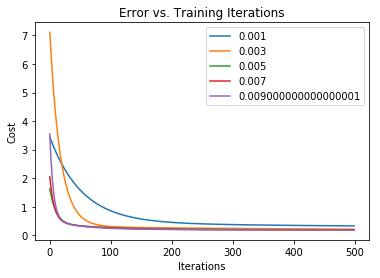

In [10]:
# Use the following code to plot out your learning rate
# iters and cost must be supplied to plot out the cost function
# You may plot multiple curves corresponding to different learning rates to justify the best one.
#
plt.xlabel('Iterations')  
plt.ylabel('Cost')  
plt.title('Error vs. Training Iterations') 
for i, l_rate in enumerate(learning_rates):
     plt.plot(cost_for_rates[i], label=str(l_rate))
#plt.plot(myGradientDescentModel.all_costs)
plt.legend(loc='best')
plt.show()

- - -
## 4. IMPLEMENTATION OF THE NORMAL EQUATION (10 pts)

In my lecture, you learn that the closed form solution of linear regression using the normal equation formulation. Using the formula does not require any feature scaling, and should be straight forward to implement: 

$
    \mathbf{\theta} = ({\mathbf{X}^{T}\mathbf{X}})^{-1}\mathbf{X}^{T}\mathbf{y}.
$

Note that you still need to add a column of 1's to the $\mathbf{
X}$ matrix to have an intercept term.

In [11]:
# Implement the normalEquation method of the MyLinearRegression Class before execute the code below:
myNormalEquationModel = MyLinearRegression()
myNormalEquationModel.fitUsingNormalEquation(X_train, y_train)

- - -
## 5. COMPARISON OF DIFFERENT IMPLEMENTATIONS (20 pts)

You should be able to evaluate and compare your gradient descent as well as normal equation implementation of linear regression. In theory, they should be the same, or at least similar. For good measures, you may also use the built-in library **Scholastic Gradient Descent (SGD)** as a third model for comparison. For each model, you must compute the Root Mean Squared Error (RMSE) as performance measure. The good news is that you can call library functions to compute these as shown below instead of writing your own code:

* Which one yields the best performance measure for your dataset?
* What is your assessment of the error? Good? Okay? Terrible?

In [12]:
from sklearn.metrics import mean_squared_error

# Use the built-in SGD Regressor model
from sklearn.linear_model import SGDRegressor
y_train = np.ravel(y_train)
mySGDModel = SGDRegressor(max_iter=1000)
mySGDModel.fit(X_train,y_train)
y_predict = mySGDModel.predict(X_test)
mse = mean_squared_error(y_test, y_predict)
mySGDModel_rmse = np.sqrt(mse)

myGradientDescentModel_rmse = myGradientDescentModel.cost
myNormalEquationModel_rmse = myNormalEquationModel.cost

print('SGD Regressor cost: ',mySGDModel_rmse)
print('Gradient Descent cost: ', myGradientDescentModel_rmse)
print('Normal Equation cost: ', myNormalEquationModel_rmse)


SGD Regressor cost:  0.5159650200748871
Gradient Descent cost:  0.19808753339562193
Normal Equation cost:  0.18618823569967824


- - -
## 6. PRESENTATION OF YOUR SOLUTION (10 pts)

Now that you need to write a short memo of one paragraph to be read by a non-technical audience (ie. your manager/boss). Focus on answering the following: 

* How can you pitch your solution to this project? 
* What did you learn so far about the problem?
* Is there any insight moving forward to improve the solution.

In [13]:
# Your paragraph goes here for this section
In this project, we have used a graduate admission dataset to predict admission acceptance probability of a candidate. We have applied Gradient Descent, 
SGD Regressor and Normal equation to evaluate our model. Our implemented Gradient Descent algorithm gives better performance than built in 
SGDRegressor model and it is also very close to the performance of Normal Equation method. 
Since Normal Equation method gives the minimum cost and our Grad. Descent gives similar performance to it, we can coclude that
our model is giving the minimum cost for the current dataset.

We have learned how data cleaning affect the performance of a model and how model parameters change in every iteration. We have also learned about
the affect of learning rate and the method to emphirically measure the best learning rate for a model.

Few features (e.g., research) has less variance in the data. Features with more variance could make the solution more robust. 

- - - 
### NEED HELP?

In case you get stuck in any step in the process, you may find some useful information from:

 * Consult my [slides](https://docs.google.com/presentation/d/10D1he89peAWaFgjtZlHpUzvOOAie_vIFT95htKCKgc0/edit?usp=sharing) and/or the textbook
 * Talk to the TA, they are available and there to help you during [office hour](https://docs.google.com/document/d/15qB84xjaS-uRJmfKmmQuCz38bLMFaoqdbuRLoZEdOYI/edit#heading=h.72k1pvft525n)
 * Come talk to me or email me <nn4pj@virginia.edu> with subject starting "CS6316 Assignment 1:...".

Best of luck and have fun!